In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

plt.style.use('ggplot')
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
!pip install transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

**Import Dataset and PreProcessing**

In [ ]:
df = pd.read_csv('/content/Ecommerce apps Reviews (Annotated) - Rokomari.csv')
print(df.shape)

(4868, 15)


In [ ]:
columns_to_drop = ['userName','userImage', 'thumbsUpCount', 'reviewCreatedVersion','at','repliedAt','appVersion','translatedContent','content']
df = df.drop(columns=columns_to_drop)

# Display the first few rows of the updated DataFrame
df.head()

,reviewId,score,replyContent,userEngagement,Usability,processedContent
0,0,5,NaN,0,Positive,Alhamdulillah best app
1,1,5,Thank you for providing your valuable feedback...,1,Positive,best app for books. But kinda pricy .That's th...
2,2,5,It is delightful to hear such positive words a...,1,Positive,Trustful institution.
3,3,5,Thank you for your review. Enjoy reading & kee...,1,Positive,Very helpful for book lovers
4,4,5,We would like to thank you for using our onlin...,1,Positive,Great App's


In [ ]:
df['replyContent'].fillna('', inplace=True)  # Replace NaN with an empty string
df.head()

,reviewId,score,replyContent,userEngagement,Usability,processedContent
0,0,5,,0,Positive,Alhamdulillah best app
1,1,5,Thank you for providing your valuable feedback...,1,Positive,best app for books. But kinda pricy .That's th...
2,2,5,It is delightful to hear such positive words a...,1,Positive,Trustful institution.
3,3,5,Thank you for your review. Enjoy reading & kee...,1,Positive,Very helpful for book lovers
4,4,5,We would like to thank you for using our onlin...,1,Positive,Great App's


In [ ]:
ax = df["score"].value_counts().sort_index()

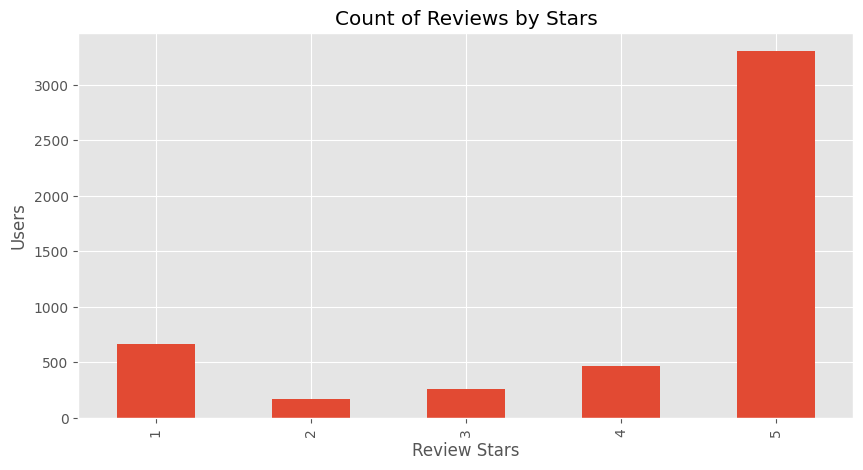

In [ ]:
ax = df["score"].value_counts().sort_index().plot(kind="bar", title="Count of Reviews by Stars", figsize=(10,5))

ax.set_xlabel('Review Stars')
ax.set_ylabel('Users')
plt.savefig('stars.pdf')
plt.show()

In [ ]:
# Get descriptive statistics:
df["Usability"].describe()

# Check for missing values:
df["Usability"].isnull().sum()


0

# **Models**

**Distillbert**

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [ ]:
!pip install --upgrade tensorflow

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm

In [ ]:
res = {}
pipeline_result_rename = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
    text = str(row['processedContent'])
    myid = i
    pipeline_result = sent_pipeline(text)
    for key,value in pipeline_result[0].items():
        pipeline_result_rename[f'pipeline_{key}'] = value
    res[myid] = pipeline_result_rename.copy()

100%|██████████| 4868/4868 [06:08<00:00, 13.20it/s]


In [ ]:
# results_df2 = pd.DataFrame(res).T
# results_df2= results_df2.reset_index().rename(columns={"index":"reviewId"})

# df['pipeline_label'] = df['reviewId'].str.split('_').str[1]
# # df['pipeline_label'] = df['pipeline_label'].astype('int64')
# df = df.dropna()
# results_df2 = results_df2.merge(df, how="left")

results_df2 = pd.DataFrame(res).T.reset_index().rename(columns={"index": "reviewId"})

# Convert 'reviewId' column to string in both DataFrames
results_df2['reviewId'] = results_df2['reviewId'].astype(str)
df['reviewId'] = df['reviewId'].astype(str)

# Merge the sentiment analysis results with the original DataFrame

In [ ]:
print("Results DataFrame:")
print(results_df2.head())

print("\nOriginal DataFrame:")
print(df.head())

# Merge the sentiment analysis results with the original DataFrame
merged_df = pd.merge(results_df2, df, on="reviewId", how="left")

print("\nMerged DataFrame:")
print(merged_df.head())

Results DataFrame:
  reviewId pipeline_label pipeline_score
0        0       POSITIVE       0.998885
1        1       NEGATIVE       0.969479
2        2       POSITIVE       0.999769
3        3       POSITIVE       0.999734
4        4       POSITIVE       0.999828

Original DataFrame:
  reviewId  score                                       replyContent  \
0        0      5                                                      
1        1      5  Thank you for providing your valuable feedback...   
2        2      5  It is delightful to hear such positive words a...   
3        3      5  Thank you for your review. Enjoy reading & kee...   
4        4      5  We would like to thank you for using our onlin...   

   userEngagement Usability                                   processedContent  
0               0  Positive                             Alhamdulillah best app  
1               1  Positive  best app for books. But kinda pricy .That's th...  
2               1  Positive           

In [ ]:
pos_reviews = merged_df[merged_df.pipeline_label == 'POSITIVE']
neg_reviews = merged_df[merged_df.pipeline_label == 'NEGATIVE']

print("Number of positive reviews:", pos_reviews.shape[0])
print("Number of negative reviews:", neg_reviews.shape[0])

neg_reviews = neg_reviews[neg_reviews.score < 4]
pos_reviews = pos_reviews[pos_reviews.score > 3]

print("Number of filtered positive reviews:", pos_reviews.shape[0])
print("Number of filtered negative reviews:", neg_reviews.shape[0])

distilbert_accuracy = (neg_reviews.shape[0] + pos_reviews.shape[0]) / results_df2.shape[0]
print("Accuracy:", distilbert_accuracy)

Number of positive reviews: 3678
Number of negative reviews: 1190
Number of filtered positive reviews: 3395
Number of filtered negative reviews: 819
Accuracy: 0.8656532456861133


In [ ]:
neg_reviews = neg_reviews[neg_reviews.score <4]
pos_reviews = pos_reviews[pos_reviews.score >3]
distilbert_accuracy = (neg_reviews.shape[0] + pos_reviews.shape[0]) / results_df2.shape[0]

In [ ]:
print(pos_reviews)

     reviewId pipeline_label pipeline_score  score  \
0           0       POSITIVE       0.998885      5   
2           2       POSITIVE       0.999769      5   
3           3       POSITIVE       0.999734      5   
4           4       POSITIVE       0.999828      5   
5           5       POSITIVE       0.999763      5   
...       ...            ...            ...    ...   
4863     4863       POSITIVE       0.998401      5   
4864     4864       POSITIVE       0.999861      5   
4865     4865       POSITIVE       0.999871      5   
4866     4866       POSITIVE       0.999829      5   
4867     4867       POSITIVE       0.997357      5   

                                           replyContent  userEngagement  \
0                                                                     0   
2     It is delightful to hear such positive words a...               1   
3     Thank you for your review. Enjoy reading & kee...               1   
4     We would like to thank you for using our onli

In [ ]:
neg_reviews = merged_df[merged_df.pipeline_label == 'NEGATIVE']
pos_reviews = merged_df[merged_df.pipeline_label == 'POSITIVE']

In [ ]:
print(pos_reviews)

     reviewId pipeline_label pipeline_score  score  \
0           0       POSITIVE       0.998885      5   
2           2       POSITIVE       0.999769      5   
3           3       POSITIVE       0.999734      5   
4           4       POSITIVE       0.999828      5   
5           5       POSITIVE       0.999763      5   
...       ...            ...            ...    ...   
4863     4863       POSITIVE       0.998401      5   
4864     4864       POSITIVE       0.999861      5   
4865     4865       POSITIVE       0.999871      5   
4866     4866       POSITIVE       0.999829      5   
4867     4867       POSITIVE       0.997357      5   

                                           replyContent  userEngagement  \
0                                                                     0   
2     It is delightful to hear such positive words a...               1   
3     Thank you for your review. Enjoy reading & kee...               1   
4     We would like to thank you for using our onli

In [ ]:
precision_pos_reviews = pos_reviews[pos_reviews.score < 4]

print(precision_pos_reviews)

distilbert_precision = pos_reviews.shape[0]/(precision_pos_reviews.shape[0]+pos_reviews.shape[0])

     reviewId pipeline_label pipeline_score  score  \
12         12       POSITIVE       0.996092      1   
30         30       POSITIVE       0.999816      1   
61         61       POSITIVE       0.963691      1   
76         76       POSITIVE       0.924837      3   
160       160       POSITIVE       0.999588      3   
...       ...            ...            ...    ...   
4656     4656       POSITIVE       0.748373      3   
4662     4662       POSITIVE       0.999069      3   
4697     4697       POSITIVE       0.999816      3   
4775     4775       POSITIVE       0.982539      3   
4781     4781       POSITIVE       0.997902      2   

                                           replyContent  userEngagement  \
12    Can you please share which features you find d...               1   
30    It seems there might be a discrepancy in your ...               1   
61    Hi, please share the details of your issue by ...               1   
76    Dear User,\n Thank you for the rating us. Kin

In [ ]:
recall_neg_reviews = neg_reviews[neg_reviews.score >3]
distilbert_recall = (neg_reviews.shape[0] + pos_reviews.shape[0])/(recall_neg_reviews.shape[0]+(neg_reviews.shape[0] + pos_reviews.shape[0]))

In [ ]:
distilbert_f1_Score = 2 * (distilbert_precision * distilbert_recall) / (distilbert_precision + distilbert_recall)

In [ ]:
print("DistilBERT accuracy: " + str(distilbert_accuracy))
print("DistilBERT Precision: " + str(distilbert_precision))
print("DistilBERT Recall: " + str(distilbert_recall))
print("DistilBERT F1 Score: " + str(distilbert_f1_Score))

DistilBERT accuracy: 0.8656532456861133
DistilBERT Precision: 0.9285533956071699
DistilBERT Recall: 0.9291849589616339
DistilBERT F1 Score: 0.928869069930137


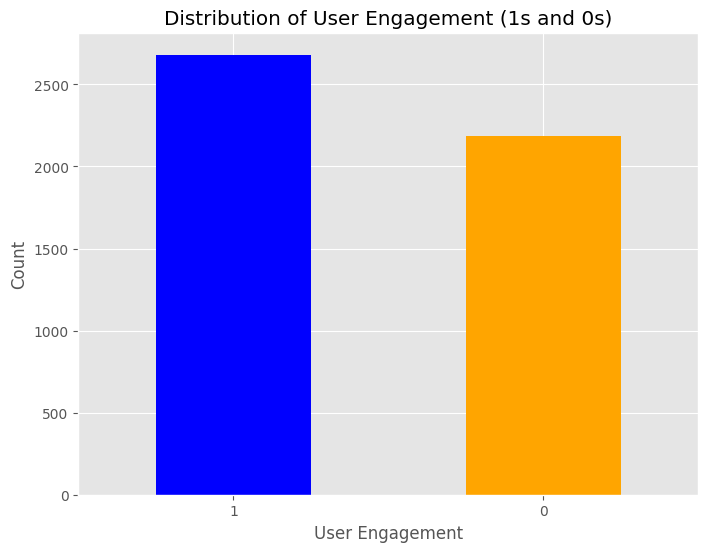

Average User Engagement: 0.5507395234182416


In [ ]:
import matplotlib.pyplot as plt
engagement_counts = merged_df['userEngagement'].value_counts()

# Plot a bar chart
plt.figure(figsize=(8, 6))
engagement_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of User Engagement (1s and 0s)')
plt.xlabel('User Engagement')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Calculate and print the average user engagement
average_engagement = merged_df['userEngagement'].mean()
print(f'Average User Engagement: {average_engagement}')

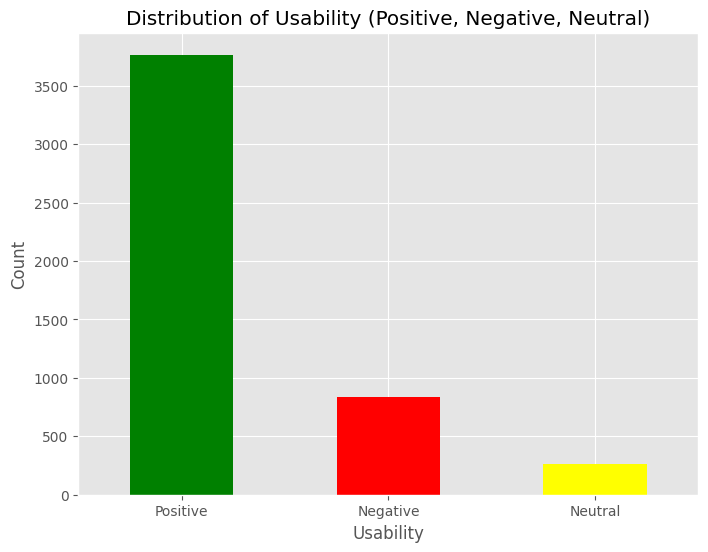

In [ ]:
usability_counts = merged_df['Usability'].value_counts()

# Plot a bar chart
plt.figure(figsize=(8, 6))
usability_counts.plot(kind='bar', color=['green', 'red', 'yellow'])
plt.title('Distribution of Usability (Positive, Negative, Neutral)')
plt.xlabel('Usability')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


**Roberta**

In [ ]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors = 'pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }
  return scores_dict

In [ ]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.1 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()  # Instantiate the analyzer

In [ ]:
res = {}
vader_result_rename = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
  text = str(row['processedContent'])
  myid = i
  vader_result = sia.polarity_scores(text)
  for key,value in vader_result.items():
    vader_result_rename[f'vader_{key}'] = value
  roberta_result = polarity_scores_roberta(text)
  both = {**vader_result_rename, **roberta_result}
  res[myid] = both

100%|██████████| 4868/4868 [12:57<00:00,  6.26it/s]


In [ ]:
results_df = pd.DataFrame(res).T.reset_index().rename(columns={"index": "reviewId"})

# Convert 'reviewId' column to string in both DataFrames
results_df['reviewId'] = results_df['reviewId'].astype(str)
df['reviewId'] = df['reviewId'].astype(str)

In [ ]:
print("Results DataFrame:")
print(results_df.head())

print("\nOriginal DataFrame:")
print(df.head())

# Merge the sentiment analysis results with the original DataFrame
merged_df2 = pd.merge(results_df, df, on="reviewId", how="left")

print("\nMerged DataFrame:")
print(merged_df2.head())

Results DataFrame:
  reviewId  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0        0      0.000      0.323      0.677          0.6369     0.002774   
1        1      0.234      0.594      0.172         -0.2382     0.476544   
2        2      0.000      0.244      0.756          0.4767     0.081619   
3        3      0.000      0.316      0.684          0.7574     0.001869   
4        4      0.000      0.196      0.804          0.6249     0.004349   

   roberta_neu  roberta_pos  
0     0.065280     0.931946  
1     0.365017     0.158439  
2     0.707130     0.211252  
3     0.049699     0.948432  
4     0.054735     0.940915  

Original DataFrame:
  reviewId  score                                       replyContent  \
0        0      5                                                      
1        1      5  Thank you for providing your valuable feedback...   
2        2      5  It is delightful to hear such positive words a...   
3        3      5  Thank you for yo

In [ ]:
tp = 0
for i, row in merged_df2.iterrows():
  positive = row["roberta_pos"]
  negative = row["roberta_neg"]
  neutral = row["roberta_neu"]
  if(max(positive, negative, neutral) == positive and (row["score"] == 4 or row["score"] == 5)):
    tp += 1
  elif(max(positive, negative, neutral) == neutral and row["score"] == 3):
    tp += 1
  elif(max(positive, negative, neutral) == negative and (row["score"] == 1 or row["score"] == 2)):
    tp += 1

roberta_accuracy = (tp) / (merged_df2.shape[0])

In [ ]:
tp = 0
fp = 0
for i,row in merged_df2.iterrows():
  positive = row["roberta_pos"]
  negative = row["roberta_neg"]
  neutral = row["roberta_neu"]
  if(max(positive,negative,neutral) == positive and row["score"]==4 or row["score"]==5):
    tp+=1
  elif(max(positive,negative,neutral) == neutral and row["score"]==3):
    tp+=1
  elif(max(positive,negative,neutral) == negative and row["score"]==1 or row["score"]==2):
    tp+=1
  elif(max(positive,negative,neutral) == positive and row["score"]<4):
    fp+=1
roberta_precision = (tp)/(tp+fp)

In [ ]:
tp = 0
fn = 0
for i,row in merged_df2.iterrows():
  positive = row["roberta_pos"]
  negative = row["roberta_neg"]
  neutral = row["roberta_neu"]
  if(max(positive,negative,neutral) == positive and row["score"]==4 or row["score"]==5):
    tp+=1
  elif(max(positive,negative,neutral) == neutral and row["score"]==3):
    tp+=1
  elif(max(positive,negative,neutral) == negative and row["score"]==1 or row["score"]==2):
    tp+=1
  if(max(positive,negative,neutral) == negative and row["score"]>2):
    fn+=1
  if(max(positive,negative,neutral) == negative and row["score"]!=3):
    fn+=1

roberta_recall = (tp)/(tp+fn)

In [ ]:
roberta_f1_Score = 2 * (roberta_precision * roberta_recall) / (roberta_precision + roberta_recall)

In [ ]:
print("Roberta accuracy: " + str(roberta_accuracy))
print("Roberta Precision: " + str(roberta_precision))
print("Roberta Recall: " + str(roberta_recall))
print("Roberta F1 Score: " + str(roberta_f1_Score))

Roberta accuracy: 0.7440427280197206
Roberta Precision: 0.9628136200716846
Roberta Recall: 0.8396171127173276
Roberta F1 Score: 0.8970051132213295
